In [6]:
import numpy as np
from numpy.linalg import norm
from math import *
from matplotlib import pyplot as plt
from matplotlib.patches import Polygon
import random
from scipy.spatial import ConvexHull
from matplotlib.animation import FuncAnimation
from matplotlib import path
import time
import cv2
from glob import glob
import os
import shutil

%matplotlib inline

<h2><u>INTRODUCTION</u></h2>

RRT stands for Rapidly Exploring Random Trees. The idea of the RRT algorithm is fairly straightforward: Points at any time are randomly generated and connected to the nearest available node. Each time a vertex is created, a check must be made that the vertex does not lie within an obstacle. Furthermore, connecting the vertex to its closest neighbor must also avoid obstacles (that is, the edge joining the new vertex and the closest vertex in the RRT tree must not intersect with an obstacle). The algorithm terminates when it converges: arrives at the goal node, or when it has ran for a given upper-bound number of iterations

<h3><b>The Environment</b></h3>
We created a 5 x 5 Environment for the RRT path planner and augmented created a scaled configuration space for a point robot using the Convex Hull function from scipy.spatial. We planted two trapezoidal obstacles in the top and bottom and a combined hollowed obstacle in the right, the start point is located here. The end point is at the bottom right of the configuration space.

In [7]:
def draw_map(obstacles):
    
    world_bounds_x = [-2.5, 2.5]
    world_bounds_y = [-2.5, 2.5]

    '''
    Draw obstacles
    '''
    
    fig = plt.figure(figsize=(10, 10))
    plt.grid()
    ax = plt.gca()
    
    ax.set_xlim(world_bounds_x)
    ax.set_ylim(world_bounds_y)
    for k in range(len(obstacles)):
        ax.add_patch(Polygon(obstacles[k]))

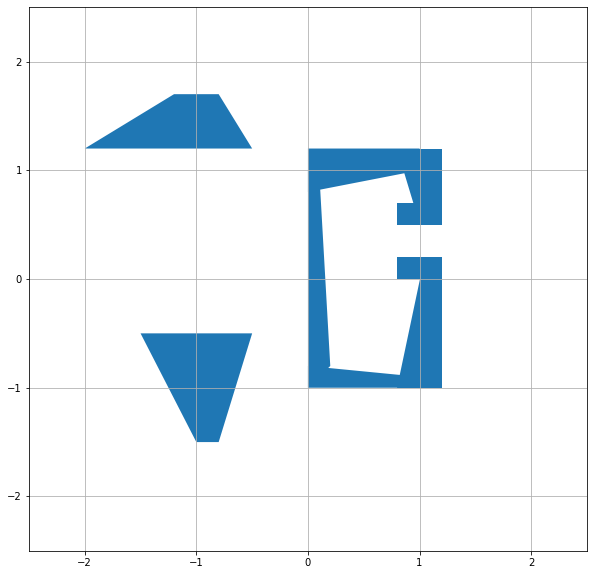

In [8]:
w = 0.2

'''
Creating configuration space obstacles of arbritary dimensions
'''

obstacles = [
              np.array([[0, -1], [1, -1], [1, -0.9], [0, w-1]]),
              np.array([[0, -1], [w, -0.8], [0.1, 1], [0.0, 1.0]]),
              np.array([[0, 1-w], [1, 1], [1, 1+w], [0, 1+w]]),
              np.array([[1-w, -1], [1+w, -1], [1+w, 0], [1, 0]]),
              np.array([[1-w, 1+w], [1+w, 1+w], [1+w, 0.5], [1, 0.5]]),
              np.array([[0.8, 0], [1+w, 0], [1+w, w], [0.8, w]]),
              np.array([[0.8, 0.5], [1+w, 0.5], [1+w, 0.5+w], [0.8, 0.5+w]]),

              np.array([[-0.5, -0.5], [-1.5, -0.5], [-1, -1.5], [-0.8, -1.5]]),

              np.array([[-0.5, 1.2], [-2.0, 1.2], [-1-w, 1.5+w], [-0.8, 1.5+w]])
            ]

draw_map(obstacles)

<h2><u>IMPLEMENTATION</u></h2>

<h4>The Robot</h4>
We first investigate the RRT algorithm with a holonomic robot. The Configuration obstacles have been scaled accordingly as to allow for the algorithm to treat the robot as a point robot. This is advantageous as when dealing with a point robot, a collision check has to be performed for only a single point.

The Kinematics for the robot are-<br>
Let $x_{icc}$ and $y_{icc}$ denote the center of the holonomic robot. ICC stands for the *instantaneous center of curvature*. This is the point about which the robot spins to orient itself without any translation in the x or y dimensions. This will lie inside the dimensions of the robot and in the case of a differential drive robot, it lies on the line joining the left and right wheels.

As the robot is holonomic, the wheel velocities are decoupled from each other. This allows for motion along the x-axis to be decoupled from motion along the y-axis.



In [9]:
class Node:
    def __init__(self):
        self.p     = [0, 0]
        self.i     = 0
        self.iPrev = 0

In [10]:
def closestNode(rrt, p):

    '''
    Finds the closest node in the tree to the sampled point
    '''
    
    distance = []
    for node in rrt:
        distance.append( sqrt((p[0] - node.p[0]) ** 2 + (p[1] - node.p[1]) ** 2) )
    distance = np.array(distance)
    
    dmin = min(distance)
    ind_min = distance.tolist().index(dmin)
    closest_node = rrt[ind_min]

    return closest_node

In [11]:
def isCollisionFreeVertex(obstacles, xy):
    
    #Checking if the point has spawned in a valid location
    
    collFree = True

    for obstacle in obstacles:
        hull = path.Path(obstacle)
        collFree = not hull.contains_points([xy])
        if hull.contains_points([xy]):
            return collFree

    return collFree

In [12]:
def isCollisionFreeEdge(obstacles, closest_vert, xy):
    
    #Checking if the line joining closest_vert and xy is free of obstacles or not
    
    closest_vert = np.array(closest_vert); xy = np.array(xy)
    collFree = True
    l = norm(closest_vert - xy)
    map_resolution = 0.01; M = int(l / map_resolution)
    if M <= 2: M = 20
    t = np.linspace(0, 1, M)
    
    for i in range(1 ,M-1):
        p = (1 - t[i]) * closest_vert + t[i] * xy
        collFree = isCollisionFreeVertex(obstacles, p) 
        if collFree == False: return False

    return collFree

In [13]:
def start_node(source):
    
    #Creates the source of class Node
    start_node = Node()
    start_node.p = source
    start_node.i = 0
    start_node.iPrev = 0 
    return start_node

In [14]:
def get_point(goal):
    
    #Generates a random point in the grid space
    
    rnd = random.random()
#     if rnd < 0.01:
        
#         #For good convergence, generating a point close to the goal
        
#         point = np.array([goal[0] + rnd, goal[0] + rnd])
#     elif rnd >= 0.01 and rnd < 0.02:
#         point = np.array([goal[0] + rnd, goal[0] - rnd]) 
#     elif rnd >= 0.02 and rnd < 0.03:
#         point = np.array([goal[0] - rnd, goal[0] - rnd]) 
#     elif rnd >= 0.03 and rnd < 0.04:
#         point = np.array([goal[0] - rnd, goal[0] + rnd]) 
#     else:
         
    point = np.array([random.random() * 5 - 2.5, random.random() * 5 - 2.5])    
    return point

In [53]:

def frames_to_video(input_path, output_path, fps):
    '''
        Function to Concatenate given frames and fps into a video file.
        Input Arguments
        input_path  : Path to the input directory containing input frames
        output_path : Path to the output directory containing the video file
        fps         : Frames per Second of the output video
        Return
        Boolean     : True is Video written successfully, False if writing is not successful.
    '''
    image_files = glob(input_path)
    #print(image_files)    
    
    image_files = glob(input_path)
    final = len(image_files)
    location = "./plots_temp"
    frames = [] 
    for f in range(1, final + 1):
        frame = cv2.imread(f"{location}/{f}.png")
        height, width, channels = frame.shape
        size = (width, height)
        frames.append(frame)

    video_writer = cv2.VideoWriter(output_path, cv2.VideoWriter_fourcc(*'DIVX'), fps, size)
    for frame in frames:
        video_writer.write(frame)

    video_writer.release()
    return True

def frames_to_video_wheel(input_path, output_path, fps):
    '''
        Function to Concatenate given frames and fps into a video file.
        Input Arguments
        input_path  : Path to the input directory containing input frames
        output_path : Path to the output directory containing the video file
        fps         : Frames per Second of the output video
        Return
        Boolean     : True is Video written successfully, False if writing is not successful.
    '''
    image_files = glob(input_path)
    #print(image_files)    
    
    image_files = glob(input_path)
    final = len(image_files)
    location = "./plots_temp_holo_wheel"
    frames = [] 
    for f in range(0, final):
        frame = cv2.imread(f"{location}/{f}.png")
        height, width, channels = frame.shape
        size = (width, height)
        frames.append(frame)

    video_writer = cv2.VideoWriter(output_path, cv2.VideoWriter_fourcc(*'DIVX'), fps, size)
    for frame in frames:
        video_writer.write(frame)

    video_writer.release()
    return True

Reached the goal after 172.09 seconds:
Number of iterations taken:  1042
Number of nodes:  716
Number of nodes on the RRT path: 58


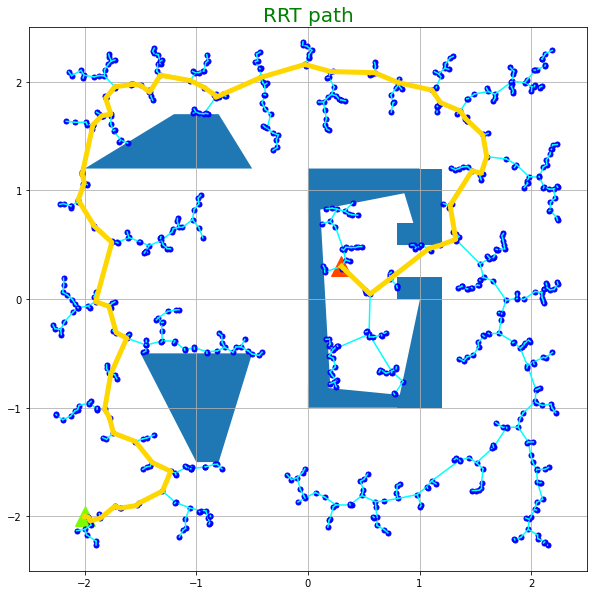

In [20]:
if __name__ == "__main__":
    maxiters  = 6969
    nearGoal = False 
    minDistGoal = 0.05 
    d = 0.20 
    if os.path.isdir("./plots_temp"):
        shutil.rmtree("./plots_temp")
    os.mkdir("./plots_temp")
    
    draw_map(obstacles)

    xy_start = np.array([0.3, 0.3]); 
    xy_goal =  np.array([-2.0, -2.0]); 
    plt.plot(xy_start[0],xy_start[1],'^',color = 'orangered', markersize = 20)
    plt.plot(xy_goal[0], xy_goal[1], '^',color = 'lawngreen',markersize = 20)

    rrt = []
    rrt.append(start_node(xy_start))

    start_time = time.time()
    iters = 0
    nodeNum = 0
    while not nearGoal and iters < maxiters:
        iters += 1        
        xy = get_point(xy_goal)
        
        closest_node = closestNode(rrt, xy)
        new_node = Node()
        new_node.p = closest_node.p + d * (xy - closest_node.p)
        new_node.i = len(rrt)
        new_node.iPrev = closest_node.i

        collFree = isCollisionFreeEdge(obstacles, closest_node.p, new_node.p)
        if not collFree:
            continue

        rrt.append(new_node)
        nodeNum += 1
        

        plt.plot(new_node.p[0], new_node.p[1], 'o',color = 'blue', markersize = 5)
        plt.plot([closest_node.p[0], new_node.p[0]], [closest_node.p[1], new_node.p[1]], color = 'aqua')
        plt.savefig("./plots_temp/" + str(nodeNum) + ".png")

        #If the current node is closer to the goal than other nodes
        
        
        if norm(np.array(xy_goal) - np.array(new_node.p)) < minDistGoal:
            goal_node = Node()
            goal_node.p = xy_goal
            goal_node.i = len(rrt)
            goal_node.iPrev = new_node.i
            if isCollisionFreeEdge(obstacles, new_node.p, goal_node.p):
                rrt.append(goal_node)
                P = [goal_node.p]
            else: 
                P = []
            end_time = time.time()
            nearGoal = True
            print('Reached the goal after %.2f seconds:' % (end_time - start_time))
        
        
    
    plt.title("RRT path", fontsize = 20, color = 'green')
    i = len(rrt) - 1

    try:
        while True:
            i = rrt[i].iPrev
            P.append(rrt[i].p)
            if i == 0:
                break
        P = np.array(P)
        print('Number of iterations taken: ',iters)
        print('Number of nodes: ', len(rrt))
        print(f"Number of nodes on the RRT path: {P.shape[0]}")
        plt.plot( P[:,0], P[:,1], color = 'gold', linewidth = 5 )
    except:
        print(f"The Rapid Exploring Random Tree algorithm wasn't able to converge in {maxiters} iterations")
    finally:
        frames_to_video("./plots_temp/*.png", "./holonomic_path.mp4", 24)

[-2. -2.]
[-1.96654496 -2.00874849]
[-1.95321136 -2.04058463]
[-1.85993224 -2.01588066]
[-1.72759075 -1.90443513]
[-1.68286086 -1.92370721]
[-1.53367424 -1.89931417]
[-1.51700806 -1.87875901]
[-1.30385147 -1.76686417]
[-1.22933702 -1.58494363]
[-1.39502418 -1.5045854 ]
[-1.54604806 -1.31091734]
[-1.74359556 -1.23286096]
[-1.77741434 -1.09434321]
[-1.82155463 -1.01411374]
[-1.76673458 -0.68874628]
[-1.62353536 -0.36016767]
[-1.718631   -0.30841444]
[-1.7833454 -0.0678476]
[-1.90262168 -0.02438052]
[-1.75690202  0.52131188]
[-1.91478763  0.66982842]
[-2.05836796  0.91022834]
[-2.00435224  1.06920981]
[-2.0231884   1.14889994]
[-1.92660562  1.60224318]
[-1.84777192  1.68543719]
[-1.76633031  1.70003316]
[-1.81332803  1.84738662]
[-1.72986332  1.95201924]
[-1.56775412  1.97453186]
[-1.49916125  1.96483487]
[-1.41797864  1.90273062]
[-1.32222725  2.05823827]
[-1.05263598  2.00909661]
[-0.92913231  1.94522262]
[-0.8383004   1.87989286]
[-0.82488123  1.85579051]
[-0.41874273  2.03916976]
[-0.

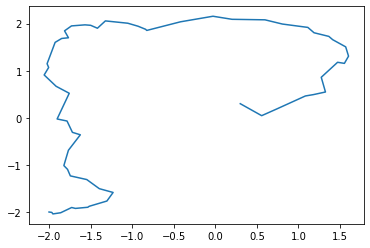

Keypoints of the algorithm in action-
<h3>At the start of the RRT</h3>
<img src = "Center_in_the_start.jpeg">

<h3>The Robot breaks out of the Hollow Obstacle</h3>
<img src = "Breaking_out_of_the_enclosure.jpeg">

<h3>The Robot explores extensively</h3>
<img src = "Exploring_Random_Path.jpeg">

<h3>The Robot approaches Convergence</h3>
<img src = "Approaching_Convergence.jpeg">

[-2. -2.]
[-1.96654496 -2.00874849]
[-1.95321136 -2.04058463]
[-1.85993224 -2.01588066]
[-1.72759075 -1.90443513]
[-1.68286086 -1.92370721]
[-1.53367424 -1.89931417]
[-1.51700806 -1.87875901]
[-1.30385147 -1.76686417]
[-1.22933702 -1.58494363]
[-1.39502418 -1.5045854 ]
[-1.54604806 -1.31091734]
[-1.74359556 -1.23286096]
[-1.77741434 -1.09434321]
[-1.82155463 -1.01411374]
[-1.76673458 -0.68874628]
[-1.62353536 -0.36016767]
[-1.718631   -0.30841444]
[-1.7833454 -0.0678476]
[-1.90262168 -0.02438052]
[-1.75690202  0.52131188]
[-1.91478763  0.66982842]
[-2.05836796  0.91022834]
[-2.00435224  1.06920981]
[-2.0231884   1.14889994]
[-1.92660562  1.60224318]
[-1.84777192  1.68543719]
[-1.76633031  1.70003316]
[-1.81332803  1.84738662]
[-1.72986332  1.95201924]
[-1.56775412  1.97453186]
[-1.49916125  1.96483487]
[-1.41797864  1.90273062]
[-1.32222725  2.05823827]
[-1.05263598  2.00909661]
[-0.92913231  1.94522262]
[-0.8383004   1.87989286]
[-0.82488123  1.85579051]
[-0.41874273  2.03916976]
[-0.

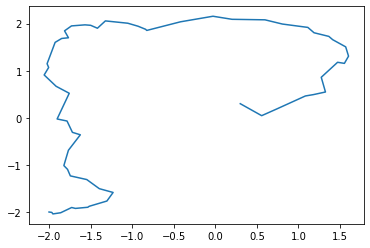

In [25]:
x = []
y = []
for r in P:
    print(r)
    x.append(r[0])
    y.append(r[1])
    
plt.plot(x,y)
plt.show()

In [43]:
def get_gradient(point1, point2):
    x1 = point1[0]; y1 = point1[1]
    x2 = point2[0]; y2 = point2[1]
    if x2 - x1 == 0:
        return 10e4
    return (y2 - y1) / (x2 - x1)

def get_angle(m1, m2):
    return atan((m1 - m2) / (1 + m1 * m2))

if os.path.isdir("./plots_temp_holo_wheel"):
    shutil.rmtree("./plots_temp_holo_wheel")
os.mkdir("./plots_temp_holo_wheel")

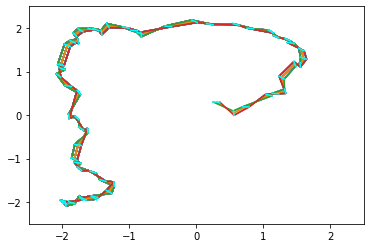

In [48]:
x = []
y = []
y_l = []
x_l = []
x_r = []
y_r = []
d = 0.05
for num, r in enumerate(P):
    x.append(r[0])
    y.append(r[1])
    P_0 = np.array([r[0], r[1]])
    P_1 = np.array([r[0], r[1]])
    P_2 = np.array([r[0], r[1]])

    if num == 0:
        P_0 = np.array([r[0], r[1] - 1])
        P_1 = np.array([r[0], r[1]])
        P_2 = np.array([P[num + 1][0], P[num + 1][1]])
        
    if num == len(P) - 1:
        pass
    
    else:
        P_0 = np.array([P[num - 1][0], P[num - 1][1]])
        P_1 = np.array([r[0], r[1]])
        P_2 = np.array([P[num + 1][0], P[num + 1][1]])
        
    m1 = get_gradient(P_0, P_1)
    m2 = get_gradient(P_1, P_2)
#     if m1 == 10e4 or m2 == 10e4:
#         continue
    rad_rot = get_angle(m1, m2)
    #print(degrees(rad_rot))
    if degrees(rad_rot) >= 0:
        y_l.append(r[1] + d * sin(rad_rot))
        x_l.append(r[0] - d * cos(rad_rot))
        y_r.append(r[1] - d * sin(rad_rot))
        x_r.append(r[0] + d * cos(rad_rot))
    else:
        y_r.append(r[1] - d * sin(rad_rot))
        x_r.append(r[0] - d * cos(rad_rot))
        y_l.append(r[1] + d * sin(rad_rot))
        x_l.append(r[0] + d * cos(rad_rot))

    xNum = np.array(x)
    yNum = np.array(y)
    x_rNum = np.array(x_r)
    y_rNum = np.array(y_r)
    x_lNum = np.array(x_l)
    y_lNum = np.array(y_l)
    #plt.figure(figsize = (20,20))
    plt.xlim([-2.5, 2.5])
    plt.ylim([-2.5, 2.5])
    plt.plot(xNum, yNum, label = "ICC")
    plt.plot(x_lNum, y_lNum, label = "left wheel")
    plt.plot(x_rNum, y_rNum, label = "right wheel")
    plt.plot([x_lNum, x_rNum], [y_lNum, y_rNum], color = 'aqua')
    #plt.legend()
    plt.savefig("./plots_temp_holo_wheel/" + str(num) + ".png")


In [55]:
frames_to_video_wheel("./plots_temp_holo_wheel/*.png", "./holonomic_wheel_path.mp4", 12)

True

### Results

The OneDrive folder containing the recordings for the holonomic and non holonomic RRT as well as wheel trajectories can be found [here](https://iiitaphyd-my.sharepoint.com/:u:/g/personal/venkata_surya_students_iiit_ac_in/ESgcywFeBldHtk0Nw8i5sEIB9E9LMCO2hgoUSYRMipcnpw?e=ZO45wC)

The workload was split among us. The completion of the assigment involved multiple meetings, trying out various implementations of which some proved to be futile and many hours of hardwork, communication and patience.

